### **Analysis for Resident Evil 2 Remake (2019)**

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pyLDAvis

In [4]:
file_path = '/Users/ql/Desktop/IS278 data/is-278-resident-evil-data-viz/re-all-data/RE2_Remake_Transcript.csv'
df = pd.read_csv(file_path)
df.head()

,Character,Gender,Playable,Line
0,Caller,NaN,Non-Playable,"Look man, I’m serious, OK? I saw this with my ..."
1,Anchor,NaN,Non-Playable,"Oh, I believe you, buddy, I believe you. Just ..."
2,Caller,NaN,Non-Playable,"OK, well, it was last Friday night - I was wal..."
3,Anchor,NaN,Non-Playable,"Whoa, whoa, whoa, OK. Tell us, be honest now, ..."
4,Caller,NaN,Non-Playable,"No man, I, I barely had a buzz on."


In [5]:
# Select only the "Line" column and drop any missing values
lines = df['Line'].dropna()

# Define a basic set of English stop words directly
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
    'will', 'just', 'don', 'should', 'now', 'll', 'one', 've', 're', 'isn', 'oh',
]

# Vectorize the text excluding stop words
vectorizer = CountVectorizer(stop_words=stop_words, max_features=1000)
X = vectorizer.fit_transform(lines)

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=20, random_state=42)

In [6]:
# Compute Perplexity Score
perplexity = lda.perplexity(X)
print(f'LDA Model Perplexity: {perplexity}')

LDA Model Perplexity: 1239.9513425482958


In [7]:
# Approximate Coherence Score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity between topics to approximate coherence
word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, None]
avg_coherence = np.mean([cosine_similarity([word_distributions[i]], [word_distributions[j]])[0, 0]
                        for i in range(len(word_distributions)) for j in range(i + 1, len(word_distributions))])
print(f'LDA Model Approximate Coherence Score: {avg_coherence}')

LDA Model Approximate Coherence Score: 0.09654425978162455


In [8]:
# Function to extract and display topics
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

# Define the number of top words to display for each topic
no_top_words = 10

# Extract and display the topics
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, no_top_words)

# Associate each line with its most relevant topic
topic_assignments = lda.transform(X).argmax(axis=1)
df['Topic'] = topic_assignments

# Group by character to see their contributions to each topic
character_contributions = df.groupby(['Character', 'Topic']).size().unstack(fill_value=0)

# Display topics and character contributions to the user
print(pd.DataFrame(topics))
print(character_contributions)

    Topic 1  Topic 2  Topic 3    Topic 4   Topic 5  Topic 6  Topic 7  \
0      help     know      got       back        ok     come     like   
1      leon    think     take      gotta  happened      ada      let   
2      need     said     stop       open     gotta  annette    looks   
3     going     didn    hello      hurry   alright     nest      get   
4      find    shoot  william        huh      calm  anybody       go   
5     sorry     like     care        got      hide       dr  station   
6     virus  walking     away  something      stay       li      way   
7  daughter     well   forget       leon       hey   dammit   police   
8    please     side       go      still     right  welcome   corpse   
9  umbrella  started    trust       stay       use    chief  walking   

    Topic 8  Topic 9 Topic 10 Topic 11    Topic 12       Topic 13    Topic 14  \
0      yeah     yeah   sherry      god  detonation           tell      claire   
1      whoa      way     hold    gonna     mi

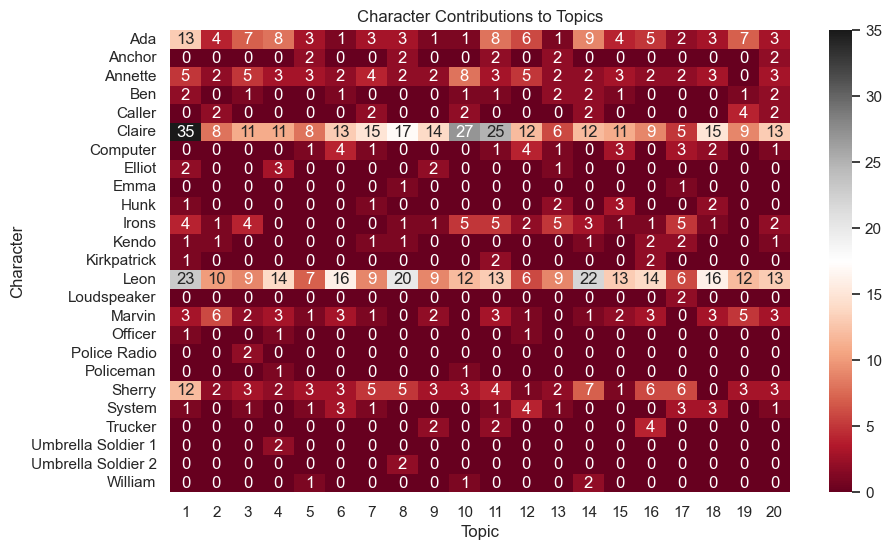

In [26]:
# Visualize the character contributions to each topic
character_contributions.columns = [f"{i+1}" for i in range(character_contributions.shape[1])]
plt.figure(figsize=(10, 6))
sns.heatmap(character_contributions, annot=True, cmap='RdGy', fmt='d')
plt.title('Character Contributions to Topics')
plt.xlabel('Topic')
plt.ylabel('Character')
plt.show()

In [28]:
# Visualize topics using pyLDAvis
term_frequency = X.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()
doc_lengths = X.sum(axis=1).A1
doc_topic_dists = lda.transform(X)
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, None]
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
pyLDAvis.display(panel)

In [30]:
pyLDAvis.save_html(panel, 're2_remake_pyldavis_visualization.html')

### **Observations for Resident Evil 2 Remake (2019):**

The top overall frequency words for all topics are "**get**", "**sherry**," "ok," "got," "**claire**."

Topics Claire contributes to the most: topic 1, 10, 11

Topics Leon contributes to the most: topic 1, 8, 14

Topic words unique to Claire: in topic 10 are "**sherry**", "hold", "**get**", "come", "**ok**"; in topic 11 are "god," "gonna," "marvin," "hell," "**get**."

Topic words unique to Leon: topic 8 are "**yeah**", "whoa", "thanks", "thing", "**ok**"; in topic 14 are "**claire**," "**get**," "coming," "think," "still."

In the overlapping topic 1, the top words are "leon", "need", "virus", "help," "umbrella."

Here, both characters are likely involved in handling the crises revolving virus and umbrellla corporation, the antagonist company. Claire seems to have a slightly more prominent contribution to the overall topics including "sherry" and "claire," and contribute to action-oriented words similarly. This could suggest a balanced partnership between the main characters, while Claire remains a nuturing figure to Sherry. 

### **What changed since Resident Evil 2 (1998) with Resident Evil 2 Remake (2019) release?**

Comparing the results for the two games 20 years part, we observed that common themes were found in the overlapped topics. Specifically, both overlapped topic--topic 1 in both games shared almost identical words including "leon" and "virus." However, "leon" and "virus" are no longer among the top overall frequency words. In addition, Claire's contributions significantly broadened across the 20 topics generated. Claire also replaced Leon as top contributor. Contributions for the rest of the characters remained approximately the same. 

In terms of unique topics, we also observed that words in topics where Claire is top contributor, actions words as well as words overlapping with the overall topic words increased. This could suggest that Claire's role is broadened and more involved with the overarching story in the reamke. 
On the other hand, Leon's role is also broadened to include more cooperative and relationship building words such as "thanks" and "ok."

These changes may suggest that while the plot and theme in the two games remain largely the same, the remake in 2019 modify the characters' development to add on the theme of collaboration and complementary roles between the main protagonists. Overall, the depth and balance in Leon and Claire's character development seem to have improved in the remake of Resident Evil 2 (2019). 

#### Referrences

Gramham, S., Weingart, S.& Milligan, I. (2012) Topic modeling and MALLET. Programming Historian. Retrieved December 10, 2024, from https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#what-is-topic-modeling-and-for-whom-is-this-useful

Mimno, D. (n.d.). MALLET: A machine learning for language toolkit. Retrieved December 10, 2024, from https://mimno.github.io/Mallet/topics

Scikit-learn. (2007). sklearn.decomposition.LatentDirichletAllocation. Scikit-learn documentation. Retrieved December 10, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#re25e5648fc37-1

Soni, P. (2020). Topic modelling using LDA. Kaggle. Retrieved December 10, 2024, from https://www.kaggle.com/code/pranjalsoni17/topic-modelling-using-lda

#### Disclaimer

Part of the codes were generated using ChatGPT, an AI language model developed by OpenAI (OpenAI, personal communication, December 10, 2024).